### Part 2: Mathematical Foundations & Linear Algebra

This section moves from the "what" to the "how," exploring the mathematical formulation of polynomial regression as a system of linear equations ($X\beta = y$).

* **Objective:** To understand the numerical methods used to solve for the model's coefficients ($\beta$) and the importance of the chosen basis.
* **Methodology:**
    1.  Construct the design matrix $X$ using a standard **power basis** (the **Vandermonde matrix**).
    2.  Explore alternative **basis functions**, such as the numerically stable **Legendre polynomials**.
    3.  Solve for $\beta$ using two different analytical methods:
        * The **Normal Equation**: $\beta = (X^T X)^{-1} X^T y$
        * The **Moore-Penrose Pseudoinverse**: $\beta = X^+ y$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set matplotlib style 
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## Polynomial Regression as a Linear Combination of Basis Functions

In the previous notebook, we explored polynomial regression by creating polynomial features and fitting models of varying degrees. Now, we'll examine the **mathematical foundations** of this approach from a linear algebra perspective.


#### The Linear Combination

Polynomial regression can be interpreted as approximating an unknown function by a finite linear combination of basis functions. For a polynomial model of degree $d$, the prediction function takes the form:

$$
\hat{y}(x) = \sum_{j=0}^{d} \beta_j \phi_j(x)
$$

where:
* $\beta_j \in \mathbb{R}$ are the model parameters (the unknowns we must find).
* $\phi_j : \mathbb{R} \to \mathbb{R}$ are the prescribed basis functions (our chosen "building blocks").

This makes explicit that the model is **linear in the parameters** ($\beta_j$) even when it is nonlinear in the input ($x$). This is the defining characteristic of a *linear model* in this context.

#### Power Basis Functions

The canonical choice of basis for polynomial regression is the **power basis**:

$$
\phi_0(x) = 1, \qquad \phi_1(x) = x, \qquad \phi_2(x) = x^2, \qquad \ldots, \qquad \phi_d(x) = x^d
$$

With this basis, the model becomes the familiar polynomial:

$$
\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^{2} + \cdots + \beta_d x^{d}
$$

This basis spans the space of univariate polynomials of degree at most $d$, denoted $\mathcal{P}_d$.

#### Matrix Formulation

Given $n$ data points $\{(x_i, y_i)\}_{i=1}^n$, we can express the model compactly in matrix notation as a system of $n$ linear equations:

$$
\mathbf{y} \approx \mathbf{X}\boldsymbol{\beta}
$$

where:
* $\mathbf{y} \in \mathbb{R}^{n}$ is the vector of observations (our $y_i$ values).
* $\boldsymbol{\beta} \in \mathbb{R}^{d+1}$ is the parameter vector (our unknown $\beta_j$ coefficients).
* $\mathbf{X} \in \mathbb{R}^{n \times (d+1)}$ is the **design matrix** defined by $X_{ij} = \phi_{j-1}(x_i)$.

For the power basis, $\mathbf{X}$ becomes a **Vandermonde matrix**:

$$
\mathbf{X} =
\begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^d \\
1 & x_2 & x_2^2 & \cdots & x_2^d \\
\vdots & \vdots & \vdots & & \vdots \\
1 & x_n & x_n^2 & \cdots & x_n^{d}
\end{bmatrix}
$$

This perspective highlights that polynomial regression is simply linear regression applied to a **nonlinear feature map**:

$$
\Phi : \mathbb{R} \to \mathbb{R}^{d+1}, \qquad \Phi(x) = \begin{bmatrix} \phi_0(x) \\ \phi_1(x) \\ \vdots \\ \phi_d(x) \end{bmatrix}
$$

Thus, polynomial regression fits a linear model in the feature space, not necessarily in the original input space.

Vandermonde Matrix Structure
Input x shape: torch.Size([50, 1])
Vandermonde matrix V shape: torch.Size([50, 6])
Polynomial degree: 5

First few rows of Vandermonde matrix (showing structure):
----------------------------------------------------------------------
x values: [-2.        -1.9183674 -1.8367347 -1.755102  -1.6734694]

Vandermonde matrix (first 5 rows, all 6 columns):
[[  1.         -2.          4.         -8.         16.        -32.       ]
 [  1.         -1.9183674   3.6801333  -7.059848   13.543382  -25.981182 ]
 [  1.         -1.8367347   3.3735943  -6.1963973  11.381138  -20.90413  ]
 [  1.         -1.755102    3.080383   -5.406387    9.48876   -16.653744 ]
 [  1.         -1.6734694   2.8005     -4.686551    7.8427997 -13.124685 ]]


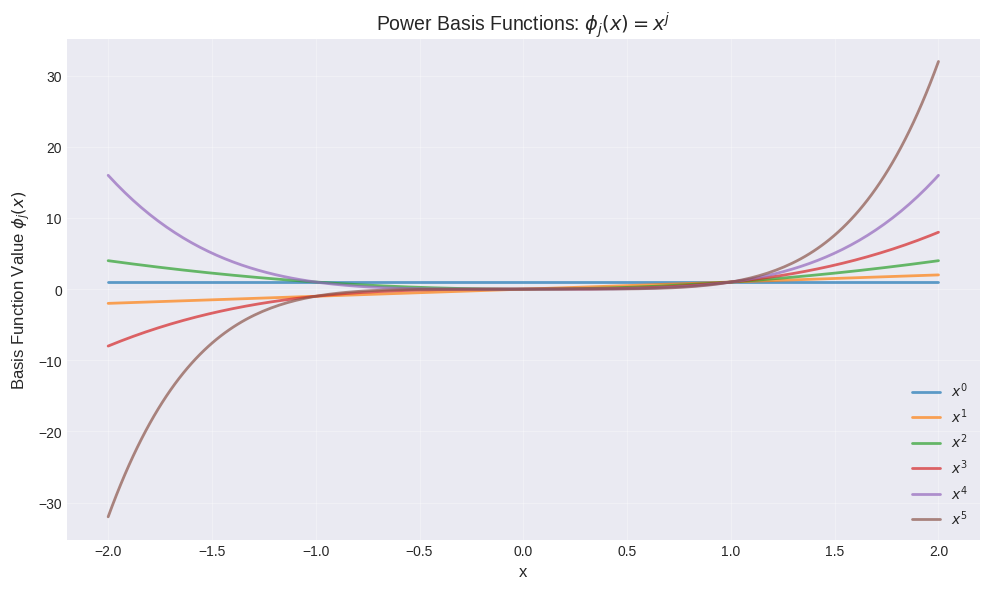


Note: The Vandermonde matrix is the design matrix X in the linear system y = Xβ
Each column represents one basis function evaluated at all data points.


In [2]:
# Generate synthetic data for demonstration
# We'll use a similar setup to the previous notebook but focus on higher degrees
n_samples = 50
x_min, x_max = -2.0, 2.0
sigma = 0.3

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values (quadratic with some higher-order terms)
y_true = 0.5 * x ** 2 + 0.1 * x ** 3

# Generate noise
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))
y = y_true + epsilon

# Function to construct Vandermonde matrix for power basis
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    
    This is equivalent to create_polynomial_features from the previous notebook.
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using einsum and broadcasting
    # We'll stack powers: for each power j, compute x^j
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    # Use broadcasting: (n, 1) ** (1, degree+1) -> (n, degree+1)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# Construct Vandermonde matrix for degree 5
degree = 5
V = construct_vandermonde_matrix(x, degree)

print("=" * 70)
print("Vandermonde Matrix Structure")
print("=" * 70)
print(f"Input x shape: {x.shape}")
print(f"Vandermonde matrix V shape: {V.shape}")
print(f"Polynomial degree: {degree}")
print(f"\nFirst few rows of Vandermonde matrix (showing structure):")
print("-" * 70)
print(f"x values: {x[:5].squeeze().numpy()}")
print(f"\nVandermonde matrix (first 5 rows, all {degree+1} columns):")
print(V[:5, :].numpy())
print("=" * 70)

plt.figure(figsize=(10, 6))

x_plot = torch.linspace(x_min, x_max, 200).unsqueeze(1)
V_plot = construct_vandermonde_matrix(x_plot, degree)

# plot each column of V_plot vs x_plot (matplotlib will plot each column)
plt.plot(x_plot.numpy(), V_plot.numpy(), linewidth=2, alpha=0.7)

plt.xlabel('x', fontsize=12)
plt.ylabel('Basis Function Value $\\phi_j(x)$', fontsize=12)
plt.title(f'Power Basis Functions: $\\phi_j(x) = x^j$', fontsize=14)
plt.legend([f'$x^{j}$' for j in range(degree + 1)], fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nNote: The Vandermonde matrix is the design matrix X in the linear system y = Xβ")
print("Each column represents one basis function evaluated at all data points.")


This script, which plots the power basis functions ($\phi_j(x) = x^j$), provides the visual evidence for a core problem in numerical analysis:

1. **The Visual Evidence of Ill-Conditioning**
   
   The plot reveals that the power basis functions are a poor choice for this task.
   
   - **Visual Similarity:** The even-powered functions ($x^2, x^4, \dots$) have a similar "U" shape, while the odd-powered functions ($x, x^3, \dots$) have a similar "S" shape.
   - **Linear Dependence:** This visual similarity means that over our data interval, the functions are not distinct enough. This translates into the column vectors of the design matrix $\mathbf{X}$ being **nearly linearly dependent**.

2. **The Numerical Consequence: A "Practically" Unsolvable System**
   
   This near-linear dependence is the definition of an **ill-conditioned** matrix.
   
   - The matrix $\mathbf{X}$ itself is ill-conditioned.
   - This means the matrix $\mathbf{X}^T \mathbf{X}$ required by the Normal Equation, $\beta = (X^T X)^{-1} X^T y$, is **catastrophically ill-conditioned**, as its condition number is the square of the original's ($\text{cond}(X^T X) \approx \text{cond}(X)^2$).
   - While $\mathbf{X}^T \mathbf{X}$ is not *singular* (a theoretical inverse exists), it is **numerically unstable**. Any attempt to compute $(X^T X)^{-1}$ will be overwhelmed by floating-point rounding errors, making the resulting $\boldsymbol{\beta}$ vector computationally meaningless.

3. **The Optimization Consequence (The "Squashed Valley")**
   
   - **The Loss Function:** Our objective function is the Mean Squared Error, $J(\beta) = \|y - X\beta\|_2^2$.
   - **The Hessian:** As we proved, the Hessian of this loss function is $H = 2(X^T X)$.
   - **The Geometry:** Since $X^T X$ is positive definite (it is a sum of squares), our Hessian is also **positive definite**. Per *Karas* (Def. 1.45, Thm. 2.14), this means our loss landscape is a **convex bowl** with a single global minimum.
   - **The Flaw (Your Point 4 Corrected):** The landscape does **not** resemble a saddle point (which has an *indefinite* Hessian, *Karas* Def. 1.48). Instead, because the Hessian is ill-conditioned, its eigenvalues (which are all positive) have a very large ratio.
   - This high condition number is the mathematical definition of a **"squashed valley"**. It is a landscape that is convex, but pathologically steep in some directions (large eigenvalues) and almost perfectly flat in others (small eigenvalues). This is the same geometry as the Rosenbrock function.

## Basis Functions: Generalizing Polynomial Regression

This "squashed valley" landscape is the worst-case scenario for the most basic optimization algorithms, like **Steepest Descent**:
* The gradient in such a valley points almost perpendicular to the direction of the minimum.
* An algorithm like Steepest Descent would fail by taking millions of tiny, "zig-zagging" steps down the steep walls, making almost no progress along the flat valley floor.

This entire analysis proves that the Vandermonde matrix is a flawed formulation. We must find a better set of "building blocks", such as the orthogonal Legendre polynomials, to create a well-conditioned problem that is stable to solve, both analytically and iteratively.

### Alternative Basis Functions

Different basis functions offer better numerical properties:

1. **Legendre Polynomials**: Orthogonal on $[-1, 1]$, better conditioning
2. **Chebyshev Polynomials**: Minimize maximum error, excellent for approximation
3. **Hermite Polynomials**: Orthogonal with respect to Gaussian weight
4. **Fourier Basis**: $\{1, \sin(x), \cos(x), \sin(2x), \cos(2x), \ldots\}$ for periodic functions
5. **Radial Basis Functions**: For non-polynomial approximations

By choosing an appropriate basis, we reformulate the problem to be numerically stable *before* we even attempt to solve it.


Running comparison...
Numerical Properties Comparison: Power Basis vs CORRECTED Legendre
Polynomial degree: 10
Number of samples: 50
Data range: [-2.0, 2.0]

Condition Numbers:
  Power basis (Vandermonde):     1.31e+04
  Legendre polynomials (Corrected): 4.45e+00
  Improvement factor:              2945.51x


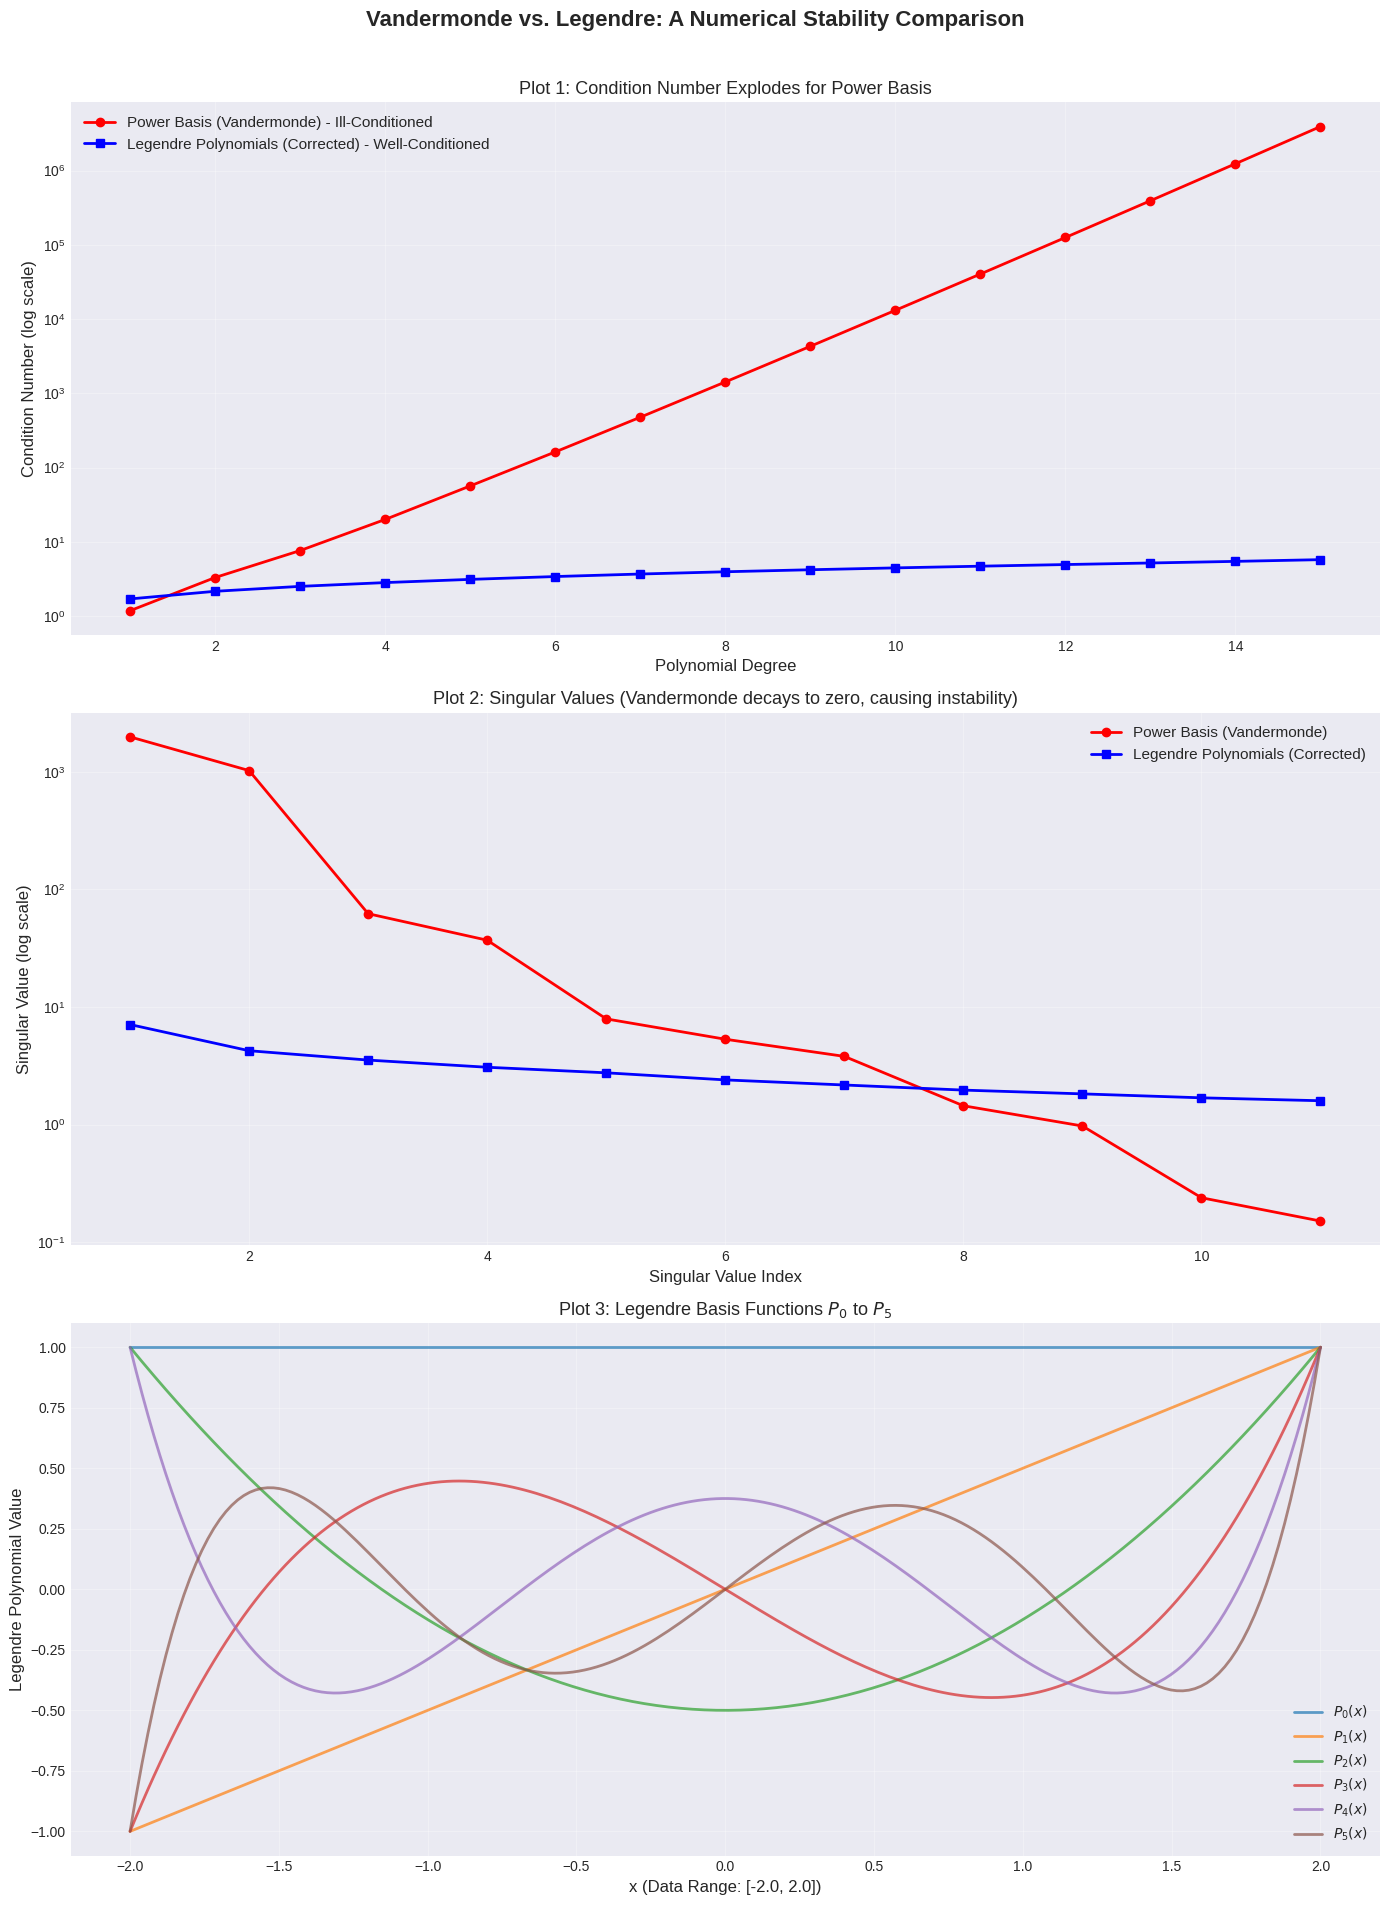

In [3]:
# Function to evaluate Legendre polynomials up to specified degree
def evaluate_legendre_polynomials(x, degree, x_min_val, x_max_val):
    """
    Evaluates Legendre polynomials up to specified degree.
    
    CRITICAL: The data MUST be rescaled from its native range [x_min, x_max]
    to the Legendre domain [-1, 1] for the orthogonality to hold.
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Rescale x from [x_min, x_max] to [-1, 1]
    x_normalized = 2.0 * (x_flat - x_min_val) / (x_max_val - x_min_val) - 1.0
   
    legendre_matrix = torch.zeros(n, degree + 1, dtype=x.dtype, device=x.device)
    
    # P_0(x) = 1
    if degree >= 0:
        legendre_matrix[:, 0] = 1.0
    
    # P_1(x) = x
    if degree >= 1:
        legendre_matrix[:, 1] = x_normalized
    
    # P_n(x) = ((2n-1)x*P_{n-1}(x) - (n-1)*P_{n-2}(x)) / n
    for j in range(2, degree + 1):
        legendre_matrix[:, j] = ((2*j - 1) * x_normalized * legendre_matrix[:, j-1] - 
                                 (j - 1) * legendre_matrix[:, j-2]) / j
    
    return legendre_matrix

# --- Experiment: Condition Number vs. Degree ---

degrees_range = range(1, 16)
cond_power_list = []
cond_legendre_list = []

print("Running comparison...")
for d in degrees_range:
    # 1. Power Basis (Vandermonde)
    V_p = construct_vandermonde_matrix(x, d)
    cond_power_list.append(torch.linalg.cond(V_p).item())
    
    # 2. Legendre Basis (Corrected)
    #    We must pass the data bounds to the corrected function.
    V_l = evaluate_legendre_polynomials(x, d, x_min, x_max)
    cond_legendre_list.append(torch.linalg.cond(V_l).item())

# We will analyze the result at degree 10
degree = 10
print("=" * 70)
print("Numerical Properties Comparison: Power Basis vs CORRECTED Legendre")
print("=" * 70)
print(f"Polynomial degree: {degree}")
print(f"Number of samples: {n_samples}")
print(f"Data range: [{x_min}, {x_max}]")
print(f"\nCondition Numbers:")
print(f"  Power basis (Vandermonde):     {cond_power_list[degree-1]:.2e}")
print(f"  Legendre polynomials (Corrected): {cond_legendre_list[degree-1]:.2e}")
print(f"  Improvement factor:              {cond_power_list[degree-1] / cond_legendre_list[degree-1]:.2f}x")
print("=" * 70)

# --- Compute singular values for both matrices (at degree 10) ---
V_power_10 = construct_vandermonde_matrix(x, degree)
V_legendre_10 = evaluate_legendre_polynomials(x, degree, x_min, x_max)

_, S_power, _ = torch.linalg.svd(V_power_10, full_matrices=False)
_, S_legendre, _ = torch.linalg.svd(V_legendre_10, full_matrices=False)

# --- Visualization (All 3 Plots) ---
fig, axes = plt.subplots(3, 1, figsize=(14, 20))
fig.suptitle("Vandermonde vs. Legendre: A Numerical Stability Comparison", fontsize=16, weight='bold')

# Plot 1: Condition numbers vs degree (The "Payoff")
axes[0].semilogy(degrees_range, cond_power_list, 'o-', linewidth=2, markersize=6, 
                 label='Power Basis (Vandermonde) - Ill-Conditioned', color='red')
axes[0].semilogy(degrees_range, cond_legendre_list, 's-', linewidth=2, markersize=6, 
                 label='Legendre Polynomials (Corrected) - Well-Conditioned', color='blue')
axes[0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0].set_ylabel('Condition Number (log scale)', fontsize=12)
axes[0].set_title('Plot 1: Condition Number Explodes for Power Basis', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Singular values (The "Deeper Why")
axes[1].semilogy(range(1, len(S_power) + 1), S_power.numpy(), 'o-', 
                 linewidth=2, markersize=6, label='Power Basis (Vandermonde)', color='red')
axes[1].semilogy(range(1, len(S_legendre) + 1), S_legendre.numpy(), 's-', 
                 linewidth=2, markersize=6, label='Legendre Polynomials (Corrected)', color='blue')
axes[1].set_xlabel('Singular Value Index', fontsize=12)
axes[1].set_ylabel('Singular Value (log scale)', fontsize=12)
axes[1].set_title('Plot 2: Singular Values (Vandermonde decays to zero, causing instability)', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Legendre basis functions (The "Visual Intuition")
# We plot the first 6 basis functions to show their shapes
plot_degree = 5
x_plot = torch.linspace(x_min, x_max, 200).unsqueeze(1)
V_legendre_plot = evaluate_legendre_polynomials(x_plot, plot_degree, x_min, x_max)

axes[2].plot(x_plot.numpy(), V_legendre_plot.numpy(), linewidth=2, alpha=0.7)
axes[2].set_xlabel(f'x (Data Range: [{x_min}, {x_max}])', fontsize=12)
axes[2].set_ylabel('Legendre Polynomial Value', fontsize=12)
axes[2].set_title(f'Plot 3: Legendre Basis Functions $P_0$ to $P_{plot_degree}$', fontsize=13)
axes[2].legend([f'$P_{j}(x)$' for j in range(plot_degree + 1)], fontsize=10, loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


### Linear Least Squares and the Normal Equation

#### The Least Squares Problem

Given a design matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ (where $p = d+1$) and a target vector $\mathbf{y} \in \mathbb{R}^{n}$, we want to find the coefficients $\boldsymbol{\beta} \in \mathbb{R}^{p}$ that minimize the **residual sum of squares**. This transforms our overdetermined system into a solvable optimization problem:

$$
\min_{\boldsymbol{\beta}} J(\boldsymbol{\beta}) = \min_{\boldsymbol{\beta}} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2
$$

This is the **Linear Least Squares** problem. The squared norm $\|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2$ measures the total squared error between our model's predictions and the actual data.

#### The Convexity of Least Squares

Before solving, we must establish the nature of this optimization problem:

* **The Objective Function:** $f(\boldsymbol{\beta}) = \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2$ is a quadratic function.
* **The Hessian:** The Hessian matrix of second derivatives is $\nabla^2 f(\boldsymbol{\beta}) = 2\mathbf{X}^T \mathbf{X}$.
* **Positive Semi-Definiteness:** For any vector $\mathbf{v}$, $\mathbf{v}^T (2\mathbf{X}^T \mathbf{X}) \mathbf{v} = 2\|\mathbf{X}\mathbf{v}\|^2 \ge 0$. Because the Hessian is positive semi-definite everywhere, the function is **convex**.
* **Global Minimizer:** A fundamental property of convex optimization is that any **stationary point** (where the gradient is zero, $\nabla f(\boldsymbol{\beta}) = 0$) is automatically a **global minimizer**.

#### The Normal Equation

To find this global minimizer, we solve for the stationary point. When $\mathbf{X}$ has **full column rank** (i.e., the columns are linearly independent), the solution is unique and given by the **Normal Equation**:

$$
\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

**Derivation:**
1.  Set the gradient of the objective function to zero:
    $$
    \nabla_{\boldsymbol{\beta}} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|^2 = 0
    $$
2.  Expand the gradient (using matrix calculus rules):
    $$
    2\mathbf{X}^T (\mathbf{X}\boldsymbol{\beta} - \mathbf{y}) = 0
    $$
3.  Rearrange the terms:
    $$
    \mathbf{X}^T \mathbf{X} \boldsymbol{\beta} = \mathbf{X}^T \mathbf{y}
    $$
4.  Solve for $\boldsymbol{\beta}$ by inverting $\mathbf{X}^T \mathbf{X}$:
    $$
    \boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
    $$

#### When the Normal Equation Works

The Normal Equation is the analytical gold standard when:
* $\mathbf{X}$ has **full column rank** (the basis functions are linearly independent).
* $\mathbf{X}^T \mathbf{X}$ is **invertible** (positive definite, ensuring strict convexity).
* The system is **well-conditioned** (the condition number is not too large).

#### Limitations & Numerical Stability

While theoretically sound, the Normal Equation faces practical challenges in numerical linear algebra:

* **Ill-conditioned systems:** If $\mathbf{X}^T \mathbf{X}$ is nearly singular (as with the Vandermonde matrix), computing its inverse explicitly is numerically unstable. The condition number of the Gram matrix is the square of the original matrix: $\kappa(\mathbf{X}^T \mathbf{X}) \approx \kappa(\mathbf{X})^2$.
* **Overparameterized systems:** When $p > n$ (more parameters than data points), $\mathbf{X}^T \mathbf{X}$ is singular, and no unique inverse exists.
* **Rank-deficient systems:** When columns of $\mathbf{X}$ are linearly dependent.

In these cases, we must compare the **Explicit Inverse** (which fails due to instability) against robust methods like **Matrix Decomposition (SVD)** and the **Moore-Penrose Pseudoinverse**.

Deg  | Cond(X^TX) | Method          | Residual   | ||beta|| (Norm) | Status
3    | 5.8e+01      | Explicit Inv    | 4.8137     | 0.50            | Solved
     |            | Decomposition   | 4.8137     | 0.50            | Solved
     |            | Pseudoinverse   | 4.8137     | 0.50            | Solved
----------------------------------------------------------------------------------------------------
8    | 2.0e+06      | Explicit Inv    | 3.4788     | 0.93            | Solved
     |            | Decomposition   | 3.4788     | 0.93            | Solved
     |            | Pseudoinverse   | 3.4788     | 0.93            | Solved
----------------------------------------------------------------------------------------------------
12   | 9.5e+09      | Explicit Inv    | 7.2918     | 4.59            | Solved
     |            | Decomposition   | 3.2321     | 4.57            | Solved
     |            | Pseudoinverse   | 3.1941     | 7.23            | Solved
--------------------------------

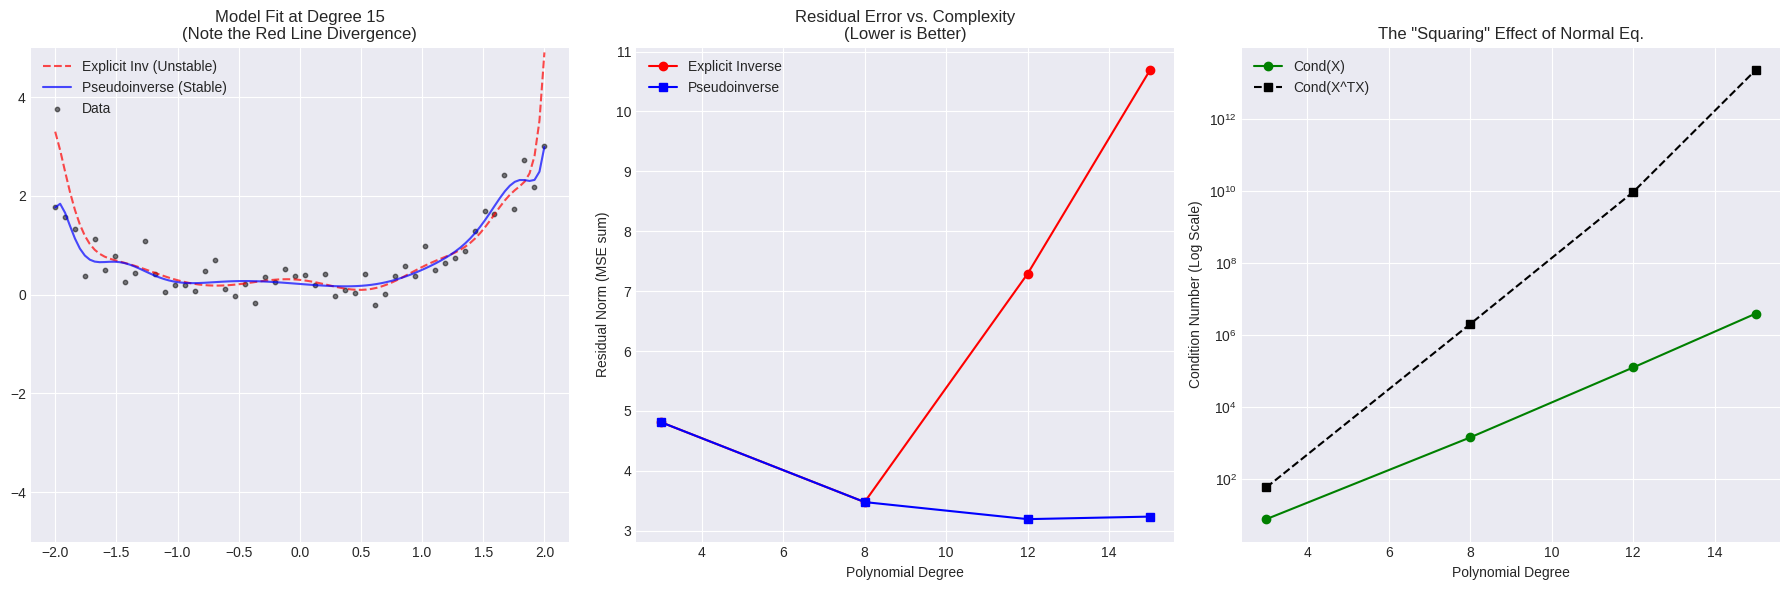

In [ ]:
# Least Squares Solvers Comparison

def compute_residuals(X, y, beta):
    """Compute residuals: r = y - Xβ."""
    y_pred = torch.einsum('ij,jk->ik', X, beta)
    residuals = y - y_pred
    return residuals

def compute_residual_norm(X, y, beta):
    """Compute ||y - Xβ||^2."""
    residuals = compute_residuals(X, y, beta)
    norm_sq = torch.einsum('ij,ij->', residuals, residuals)
    return norm_sq.item()

def solve_normal_equation_explicit(X, y):
    """
    Solves using the explicit inverse: β = (X^T X)^(-1) X^T y.
    WARNING: Numerically unstable for ill-conditioned matrices.
    """
    XTX = torch.einsum('ni,nj->ij', X, X)
    XTy = torch.einsum('ni,nj->ij', X, y)
    try:
        inv_XTX = torch.linalg.inv(XTX)
        beta = torch.einsum('ij,jk->ik', inv_XTX, XTy)
        return beta
    except RuntimeError:
        return None

def solve_via_decomposition(X, y):
    """
    Solves using Cholesky or LU decomposition (torch.linalg.solve).
    """
    XTX = torch.einsum('ni,nj->ij', X, X)
    XTy = torch.einsum('ni,nj->ij', X, y)
    return torch.linalg.solve(XTX, XTy)

def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y.
    """
    X_pinv = torch.linalg.pinv(X)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    return beta

# --- 3. Execution & Visualization ---

degrees_to_test = [3, 8, 12, 15]
results = {d: {} for d in degrees_to_test}

print("=" * 100)
print(f"{'Deg':<4} | {'Cond(X^TX)':<10} | {'Method':<15} | {'Residual':<10} | {'||beta|| (Norm)':<15} | {'Status'}")
print("=" * 100)

# Lists for plotting
deg_plot = []
res_explicit_plot = []
res_pinv_plot = []
cond_X_plot = []
cond_XTX_plot = []

for degree in degrees_to_test:
    X = construct_vandermonde_matrix(x, degree)
    
    cond_X = torch.linalg.cond(X).item()
    XTX = torch.einsum('ni,nj->ij', X, X)
    cond_XTX = torch.linalg.cond(XTX).item()
    
    # Save for plotting
    deg_plot.append(degree)
    cond_X_plot.append(cond_X)
    cond_XTX_plot.append(cond_XTX)

    # Method A: Explicit Inverse
    beta_explicit = solve_normal_equation_explicit(X, y)
    if beta_explicit is not None:
        res_explicit = compute_residual_norm(X, y, beta_explicit)
        norm_explicit = torch.norm(beta_explicit).item()
        results[degree]['explicit'] = beta_explicit
        status_explicit = "Solved"
    else:
        res_explicit = float('nan')
        norm_explicit = float('nan')
        results[degree]['explicit'] = None
        status_explicit = "FAILED"
    res_explicit_plot.append(res_explicit)

    # Method B: Decomposition
    try:
        beta_decomp = solve_via_decomposition(X, y)
        res_decomp = compute_residual_norm(X, y, beta_decomp)
        norm_decomp = torch.norm(beta_decomp).item()
        status_decomp = "Solved"
    except RuntimeError:
        res_decomp = float('inf')
        norm_decomp = float('inf')
        status_decomp = "Unstable"

    # Method C: Pseudoinverse
    beta_pinv = solve_pseudoinverse(X, y)
    res_pinv = compute_residual_norm(X, y, beta_pinv)
    norm_pinv = torch.norm(beta_pinv).item()
    results[degree]['pinv'] = beta_pinv
    res_pinv_plot.append(res_pinv)

    print(f"{degree:<4} | {cond_XTX:.1e}      | {'Explicit Inv':<15} | {res_explicit:<10.4f} | {norm_explicit:<15.2f} | {status_explicit}")
    print(f"{'':<4} | {'':<10} | {'Decomposition':<15} | {res_decomp:<10.4f} | {norm_decomp:<15.2f} | {status_decomp}")
    print(f"{'':<4} | {'':<10} | {'Pseudoinverse':<15} | {res_pinv:<10.4f} | {norm_pinv:<15.2f} | Solved")
    print("-" * 100)


# --- 4. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Visualizing the Fit (We switch to Degree 15 to see the visual failure)
d_viz = 15
X_plot = construct_vandermonde_matrix(torch.linspace(x_min, x_max, 100).unsqueeze(1), d_viz)

# Predict using the betas we stored
if results[d_viz]['explicit'] is not None:
    y_explicit = torch.einsum('ij,jk->ik', X_plot, results[d_viz]['explicit'])
    axes[0].plot(torch.linspace(x_min, x_max, 100), y_explicit, 'r--', label='Explicit Inv (Unstable)', alpha=0.7)

y_pinv = torch.einsum('ij,jk->ik', X_plot, results[d_viz]['pinv'])
axes[0].plot(torch.linspace(x_min, x_max, 100), y_pinv, 'b-', label='Pseudoinverse (Stable)', alpha=0.7)

axes[0].scatter(x, y, c='k', s=10, alpha=0.5, label='Data')
axes[0].set_title(f'Model Fit at Degree {d_viz}\n(Note the Red Line Divergence)')
axes[0].set_ylim(-5, 5)
axes[0].legend()

# Plot 2: Residuals vs Degree (The "Explosion")
axes[1].plot(deg_plot, res_explicit_plot, 'r-o', label='Explicit Inverse')
axes[1].plot(deg_plot, res_pinv_plot, 'b-s', label='Pseudoinverse')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Residual Norm (MSE sum)')
axes[1].set_title('Residual Error vs. Complexity\n(Lower is Better)')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Condition Number Squaring (The "Cause")
axes[2].semilogy(deg_plot, cond_X_plot, 'g-o', label='Cond(X)')
axes[2].semilogy(deg_plot, cond_XTX_plot, 'k--s', label='Cond(X^TX)')
axes[2].set_xlabel('Polynomial Degree')
axes[2].set_ylabel('Condition Number (Log Scale)')
axes[2].set_title('The "Squaring" Effect of Normal Eq.')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## The Moore-Penrose Pseudoinverse

### What is the Pseudoinverse?

The **Moore-Penrose pseudoinverse** $\mathbf{X}^+$ is a generalization of the matrix inverse that exists for **any** matrix, even if it's not square or not invertible.

For a matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$, the pseudoinverse $\mathbf{X}^+ \in \mathbb{R}^{p \times n}$ is the unique matrix satisfying:

1. $\mathbf{X} \mathbf{X}^+ \mathbf{X} = \mathbf{X}$
2. $\mathbf{X}^+ \mathbf{X} \mathbf{X}^+ = \mathbf{X}^+$
3. $(\mathbf{X} \mathbf{X}^+)^T = \mathbf{X} \mathbf{X}^+$
4. $(\mathbf{X}^+ \mathbf{X})^T = \mathbf{X}^+ \mathbf{X}$

### Connection to SVD

The pseudoinverse can be computed using the **Singular Value Decomposition (SVD)**:

If $\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$ (SVD), then:

$$\mathbf{X}^+ = \mathbf{V} \boldsymbol{\Sigma}^+ \mathbf{U}^T$$

where $\boldsymbol{\Sigma}^+$ is formed by taking the reciprocal of non-zero singular values and transposing.

### Solving Least Squares with Pseudoinverse

The least squares solution can be written as:

$$\boldsymbol{\beta} = \mathbf{X}^+ \mathbf{y}$$

This formula works in **all cases**:
- When $\mathbf{X}$ has full column rank: $\mathbf{X}^+ = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ (same as Normal Equation)
- When $\mathbf{X}$ is rank-deficient: gives the minimum-norm solution
- When $p > n$ (overparameterized): gives a solution (though not unique)

### Why It Matters

The pseudoinverse is **numerically more stable** than the Normal Equation because:
- It uses SVD, which is more robust to ill-conditioning
- It handles near-zero singular values gracefully (sets them to zero)
- It avoids computing $(\mathbf{X}^T \mathbf{X})^{-1}$, which can be ill-conditioned even when $\mathbf{X}$ is only moderately ill-conditioned

### When to Use Each Method

- **Normal Equation**: Use when system is well-conditioned and you want computational efficiency
- **Pseudoinverse**: Use when system may be ill-conditioned, rank-deficient, or overparameterized
- **Regularized methods**: Use when you want to explicitly control model complexity (Ridge, Lasso)

The pseudoinverse provides a robust, general-purpose solution to the least squares problem.


In [5]:
# Function to predict using coefficients
def predict_polynomial_basis(x, beta, basis_func, degree):
    """
    Predict using coefficients and basis functions.
    """
    X = basis_func(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X, beta)
    return y_pred

# Compare fits for well-conditioned case
print("=" * 70)
print("Visualization: Well-Conditioned Case (Degree 3)")
print("=" * 70)

degree_viz_well = 3
X_viz_well = construct_vandermonde_matrix(x, degree_viz_well)
beta_normal_viz_well = solve_normal_equation(X_viz_well, y)
beta_pinv_viz_well = solve_pseudoinverse(X_viz_well, y)

# Generate smooth x for plotting
x_plot = torch.linspace(x_min, x_max, 300).unsqueeze(1)
X_plot_well = construct_vandermonde_matrix(x_plot, degree_viz_well)

y_pred_normal_well = torch.einsum('ij,jk->ik', X_plot_well, beta_normal_viz_well)
y_pred_pinv_well = torch.einsum('ij,jk->ik', X_plot_well, beta_pinv_viz_well)

# Compare fits for ill-conditioned case
print("\n" + "=" * 70)
print("Visualization: Ill-Conditioned Case (Degree 12)")
print("=" * 70)

degree_viz_ill = 12
X_viz_ill = construct_vandermonde_matrix(x, degree_viz_ill)
cond_viz_ill = torch.linalg.cond(X_viz_ill).item()
print(f"Condition number: {cond_viz_ill:.2e}")

beta_normal_viz_ill = solve_normal_equation(X_viz_ill, y)
beta_pinv_viz_ill = solve_pseudoinverse(X_viz_ill, y)

X_plot_ill = construct_vandermonde_matrix(x_plot, degree_viz_ill)
y_pred_normal_ill = torch.einsum('ij,jk->ik', X_plot_ill, beta_normal_viz_ill)
y_pred_pinv_ill = torch.einsum('ij,jk->ik', X_plot_ill, beta_pinv_viz_ill)

# Compute true function for comparison
y_true_plot = 0.5 * x_plot ** 2 + 0.1 * x_plot ** 3

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Well-conditioned case - Normal Equation
axes[0, 0].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[0, 0].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[0, 0].plot(x_plot.numpy(), y_pred_normal_well.numpy(), 'r-', linewidth=2, 
                label='Normal Equation fit', alpha=0.8)
axes[0, 0].set_xlabel('x', fontsize=12)
axes[0, 0].set_ylabel('y', fontsize=12)
axes[0, 0].set_title(f'Well-Conditioned (Degree {degree_viz_well}): Normal Equation', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Well-conditioned case - Pseudoinverse
axes[0, 1].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[0, 1].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[0, 1].plot(x_plot.numpy(), y_pred_pinv_well.numpy(), 'b-', linewidth=2, 
                label='Pseudoinverse fit', alpha=0.8)
axes[0, 1].set_xlabel('x', fontsize=12)
axes[0, 1].set_ylabel('y', fontsize=12)
axes[0, 1].set_title(f'Well-Conditioned (Degree {degree_viz_well}): Pseudoinverse', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Ill-conditioned case - Normal Equation (may be unstable)
axes[1, 0].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[1, 0].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[1, 0].plot(x_plot.numpy(), y_pred_normal_ill.numpy(), 'r-', linewidth=2, 
                label='Normal Equation fit', alpha=0.8)
axes[1, 0].set_xlabel('x', fontsize=12)
axes[1, 0].set_ylabel('y', fontsize=12)
axes[1, 0].set_title(f'Ill-Conditioned (Degree {degree_viz_ill}, cond={cond_viz_ill:.1e}): Normal Equation', 
                     fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.05, 0.95, 'Numerically\nUnstable!', 
                transform=axes[1, 0].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Plot 4: Ill-conditioned case - Pseudoinverse (more stable)
axes[1, 1].scatter(x.numpy(), y.numpy(), alpha=0.6, label='Data points', s=40, color='gray')
axes[1, 1].plot(x_plot.numpy(), y_true_plot.numpy(), 'g--', linewidth=2, 
                label='True function', alpha=0.7)
axes[1, 1].plot(x_plot.numpy(), y_pred_pinv_ill.numpy(), 'b-', linewidth=2, 
                label='Pseudoinverse fit', alpha=0.8)
axes[1, 1].set_xlabel('x', fontsize=12)
axes[1, 1].set_ylabel('y', fontsize=12)
axes[1, 1].set_title(f'Ill-Conditioned (Degree {degree_viz_ill}, cond={cond_viz_ill:.1e}): Pseudoinverse', 
                     fontsize=13)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].text(0.05, 0.95, 'Numerically\nStable!', 
                transform=axes[1, 1].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

# Additional visualization: Residual comparison
degrees_residual = [3, 5, 7, 9, 11, 13]
residual_norms_normal = []
residual_norms_pinv = []

for d in degrees_residual:
    X_res = construct_vandermonde_matrix(x, d)
    beta_norm = solve_normal_equation(X_res, y)
    beta_pinv = solve_pseudoinverse(X_res, y)
    
    residual_norms_normal.append(compute_residual_norm(X_res, y, beta_norm))
    residual_norms_pinv.append(compute_residual_norm(X_res, y, beta_pinv))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(degrees_residual, residual_norms_normal, 'o-', linewidth=2, markersize=8, 
        label='Normal Equation', color='red')
ax.plot(degrees_residual, residual_norms_pinv, 's-', linewidth=2, markersize=8, 
        label='Pseudoinverse', color='blue')
ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('Residual Norm ||y - Xβ||²', fontsize=12)
ax.set_title('Residual Norms: Normal Equation vs Pseudoinverse', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Summary")
print("=" * 70)
print("1. For well-conditioned systems, both methods give similar results.")
print("2. For ill-conditioned systems, the Normal Equation becomes numerically unstable.")
print("3. The pseudoinverse provides a more robust solution using SVD.")
print("4. High-degree polynomials with power basis lead to ill-conditioned design matrices.")
print("5. Using better basis functions (e.g., Legendre polynomials) improves conditioning.")
print("=" * 70)


Visualization: Well-Conditioned Case (Degree 3)


NameError: name 'solve_normal_equation' is not defined